# Denoising Diffusion Probabilistic Models with MedNIST Dataset

This tutorial illustrates how to use MONAI for training a denoising diffusion probabilistic model (DDPM)[1] to create
synthetic 2D images.

[1] - Ho et al. "Denoising Diffusion Probabilistic Models" https://arxiv.org/abs/2006.11239

TODO: Add Open in Colab

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import ignite" || pip install -q pytorch-ignite

%matplotlib inline

## Setup imports

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import os
import shutil
import tempfile
from typing import Dict, Mapping, Optional, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
from ignite.contrib.handlers import ProgressBar
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.engines import PrepareBatch, SupervisedEvaluator, SupervisedTrainer, default_prepare_batch
from monai.handlers import MeanAbsoluteError, MeanSquaredError, StatsHandler, ValidationHandler, from_engine
from monai.utils import first, set_determinism

from generative.inferers import DiffusionInferer

# TODO: Add right import reference after deployed
from generative.networks.nets import DiffusionModelUNet
from generative.schedulers import DDPMScheduler

print_config()

MONAI version: 1.1.dev2246
Numpy version: 1.23.3
Pytorch version: 1.8.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c81b9467b43bb14e77956729d10f2aef4d69deec
MONAI __file__: /media/walter/Storage/Projects/GenerativeModels/venv/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.2.0
Tensorboard version: 2.11.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.9.0+cu111
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai

## Setup data directory

You can specify a directory with the MONAI_DATA_DIRECTORY environment variable.

This allows you to save results and reuse downloads.

If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp4s7ozrr7


## Set deterministic training for reproducibility

In [4]:
set_determinism(0)

## Setup MedNIST Dataset and training and validation dataloaders
In this tutorial, we will train our models on the MedNIST dataset available on MONAI
(https://docs.monai.io/en/stable/apps.html#monai.apps.MedNISTDataset). In order to train faster, we will select just
one of the available classes ("Hand"), resulting in a training set with 7999 2D images.

In [5]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, progress=False, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]

2022-11-26 00:25:55,677 - INFO - Downloaded: /tmp/tmp4s7ozrr7/MedNIST.tar.gz
2022-11-26 00:25:55,746 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2022-11-26 00:25:55,746 - INFO - Writing into directory: /tmp/tmp4s7ozrr7.


Here we use transforms to augment the training dataset:

1. `LoadImaged` loads the hands images from files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `ScaleIntensityRanged` extracts intensity range [0, 255] and scales to [0, 1].
1. `RandAffined` efficiently performs rotate, scale, shear, translate, etc. together based on PyTorch affine transform.

In [6]:
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[64, 64],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)
train_ds = CacheDataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4, persistent_workers=True)

Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7999/7999 [00:04<00:00, 1792.22it/s]


In [7]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, progress=False, seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "Hand"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=4, persistent_workers=True)

2022-11-26 00:26:19,327 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2022-11-26 00:26:19,327 - INFO - File exists: /tmp/tmp4s7ozrr7/MedNIST.tar.gz, skipped downloading.
2022-11-26 00:26:19,328 - INFO - Non-empty folder exists in /tmp/tmp4s7ozrr7/MedNIST, skipped extracting.


Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1005/1005 [00:00<00:00, 1773.89it/s]


### Visualisation of the training images

batch shape: (8, 1, 64, 64)


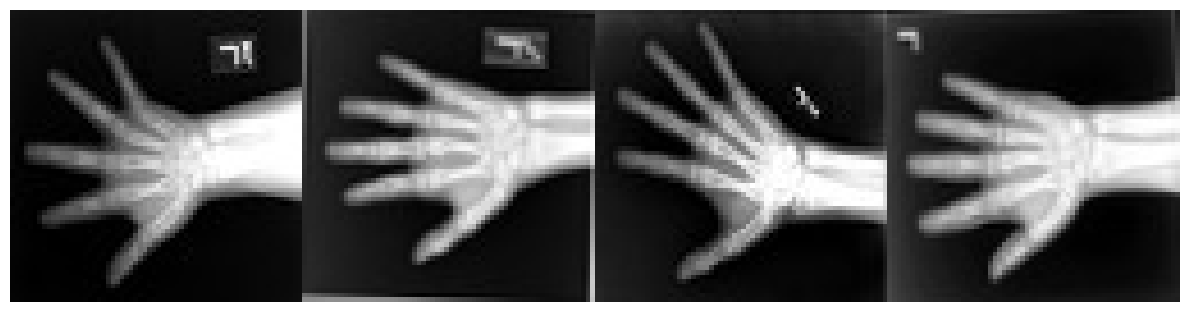

In [8]:
check_data = first(train_loader)
print(f"batch shape: {check_data['image'].shape}")
image_visualisation = torch.cat(
    [check_data["image"][0, 0], check_data["image"][1, 0], check_data["image"][2, 0], check_data["image"][3, 0]], dim=1
)
plt.figure("training images", (12, 6))
plt.imshow(image_visualisation, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

### Define network, scheduler, optimizer, and inferer
At this step, we instantiate the MONAI components to create a DDPM, the UNET, the noise scheduler, and the inferer used for training and sampling. We are using
the original DDPM scheduler containing 1000 timesteps in its Markov chain, and a 2D UNET with attention mechanisms
in the 2nd and 3rd levels, each with 1 attention head.

In [9]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(64, 128, 128),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=128,
)
model.to(device)

scheduler = DDPMScheduler(
    num_train_timesteps=1000,
)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

### Define a class for preparing batches

In [10]:
class DiffusionPrepareBatch(PrepareBatch):
    """
    This class is used as a callable for the `prepare_batch` parameter of engine classes for diffusion training.

    Assuming a supervised training process, it will generate a noise field using `get_noise` for an input image, and
    return the image and noise field as the image/target pair plus the noise field the kwargs under the key "noise".
    This assumes the inferer being used in conjunction with this class expects a "noise" parameter to be provided.

    If the `condition_name` is provided, this must refer to a key in the input dictionary containing the condition
    field to be passed to the inferer. This will appear in the keyword arguments under the key "condition".

    """

    def __init__(self, condition_name: Optional[str] = None):
        self.condition_name = condition_name

    def get_noise(self, images):
        """Returns the noise tensor for input tensor `images`, override this for different noise distributions."""
        return torch.randn_like(images)

    def __call__(
        self,
        batchdata: Dict[str, torch.Tensor],
        device: Optional[Union[str, torch.device]] = None,
        non_blocking: bool = False,
        **kwargs,
    ):
        images, _ = default_prepare_batch(batchdata, device, non_blocking, **kwargs)
        noise = self.get_noise(images).to(device, non_blocking=non_blocking, **kwargs)

        kwargs = {"noise": noise}

        if self.condition_name is not None and isinstance(batchdata, Mapping):
            kwargs["conditioning"] = batchdata[self.condition_name].to(device, non_blocking=non_blocking, **kwargs)

        # return input, target, arguments, and keyword arguments where noise is the target and also a keyword value
        return images, noise, (), kwargs

### Model training
Here, we are training our model for 75 epochs (training time: ~50 minutes).

In [11]:
n_epochs = 75
val_interval = 5

val_handlers = [StatsHandler(name="train_log", output_transform=lambda x: None)]

evaluator = SupervisedEvaluator(
    device=device,
    val_data_loader=val_loader,
    network=model,
    inferer=inferer,
    prepare_batch=DiffusionPrepareBatch(),
    key_val_metric={"val_mean_abs_error": MeanAbsoluteError(output_transform=from_engine(["pred", "label"]))},
    val_handlers=val_handlers,
)


train_handlers = [
    ValidationHandler(validator=evaluator, interval=val_interval, epoch_level=True),
    # StatsHandler(name="train_log", tag_name="train_loss", output_transform=from_engine(["loss"], first=True)),
]

trainer = SupervisedTrainer(
    device=device,
    max_epochs=n_epochs,
    train_data_loader=train_loader,
    network=model,
    optimizer=optimizer,
    loss_function=torch.nn.MSELoss(),
    inferer=inferer,
    prepare_batch=DiffusionPrepareBatch(),
    key_train_metric={"train_acc": MeanSquaredError(output_transform=from_engine(["pred", "label"]))},
    train_handlers=train_handlers,
)
ProgressBar(
    persist=True,
    bar_format="[{n_fmt}/{total_fmt}] {percentage:3.0f}%|{postfix} [{elapsed}<{remaining}]",
).attach(
    trainer,
    output_transform=from_engine(["loss"]),
)


trainer.run()

2022-11-26 00:26:23,940 - Engine run resuming from iteration 0, epoch 0 until 75 epochs


[1/1000]   0%| [00:00<?]

/media/walter/Storage/Projects/GenerativeModels/venv/lib/python3.8/site-packages/ignite/contrib/handlers/base_logger.py:172: UserWarning: Logger output_handler can not log metrics value type <class 'list'>
  warnings.warn(f"Logger output_handler can not log metrics value type {type(value)}")


2022-11-26 00:27:34,129 - Got new best metric of train_acc: 0.1597186028957367
2022-11-26 00:27:34,130 - Epoch[1] Complete. Time taken: 00:01:10.146


[1/1000]   0%| [00:00<?]

2022-11-26 00:28:44,143 - Epoch[2] Complete. Time taken: 00:01:10.012


[1/1000]   0%| [00:00<?]

2022-11-26 00:29:54,370 - Epoch[3] Complete. Time taken: 00:01:10.227


[1/1000]   0%| [00:00<?]

2022-11-26 00:31:04,980 - Epoch[4] Complete. Time taken: 00:01:10.609


[1/1000]   0%| [00:00<?]

2022-11-26 00:32:16,051 - Engine run resuming from iteration 0, epoch 4 until 5 epochs
2022-11-26 00:32:19,550 - Got new best metric of val_mean_abs_error: 0.0573042631149292
2022-11-26 00:32:19,551 - Epoch[5] Metrics -- val_mean_abs_error: 0.0573 
2022-11-26 00:32:19,551 - Key metric: val_mean_abs_error best value: 0.0573042631149292 at epoch: 5
2022-11-26 00:32:19,552 - Epoch[5] Complete. Time taken: 00:00:03.388
2022-11-26 00:32:19,552 - Engine run complete. Time taken: 00:00:03.500
2022-11-26 00:32:19,553 - Epoch[5] Complete. Time taken: 00:01:14.573


[1/1000]   0%| [00:00<?]

2022-11-26 00:33:30,367 - Epoch[6] Complete. Time taken: 00:01:10.813


[1/1000]   0%| [00:00<?]

2022-11-26 00:34:41,475 - Epoch[7] Complete. Time taken: 00:01:11.107


[1/1000]   0%| [00:00<?]

2022-11-26 00:35:52,513 - Epoch[8] Complete. Time taken: 00:01:11.038


[1/1000]   0%| [00:00<?]

2022-11-26 00:37:03,482 - Epoch[9] Complete. Time taken: 00:01:10.969


[1/1000]   0%| [00:00<?]

2022-11-26 00:38:14,229 - Engine run resuming from iteration 0, epoch 9 until 10 epochs
2022-11-26 00:38:17,527 - Epoch[10] Metrics -- val_mean_abs_error: 0.0528 
2022-11-26 00:38:17,527 - Key metric: val_mean_abs_error best value: 0.0573042631149292 at epoch: 5
2022-11-26 00:38:17,528 - Epoch[10] Complete. Time taken: 00:00:03.298
2022-11-26 00:38:17,528 - Engine run complete. Time taken: 00:00:03.299
2022-11-26 00:38:17,529 - Epoch[10] Complete. Time taken: 00:01:14.046


[1/1000]   0%| [00:00<?]

2022-11-26 00:39:28,385 - Epoch[11] Complete. Time taken: 00:01:10.855


[1/1000]   0%| [00:00<?]

2022-11-26 00:40:39,532 - Epoch[12] Complete. Time taken: 00:01:11.147


[1/1000]   0%| [00:00<?]

2022-11-26 00:41:50,419 - Epoch[13] Complete. Time taken: 00:01:10.887


[1/1000]   0%| [00:00<?]

2022-11-26 00:43:01,559 - Epoch[14] Complete. Time taken: 00:01:11.139


[1/1000]   0%| [00:00<?]

2022-11-26 00:44:12,669 - Engine run resuming from iteration 0, epoch 14 until 15 epochs
2022-11-26 00:44:15,938 - Epoch[15] Metrics -- val_mean_abs_error: 0.0470 
2022-11-26 00:44:15,938 - Key metric: val_mean_abs_error best value: 0.0573042631149292 at epoch: 5
2022-11-26 00:44:15,939 - Epoch[15] Complete. Time taken: 00:00:03.269
2022-11-26 00:44:15,939 - Engine run complete. Time taken: 00:00:03.270
2022-11-26 00:44:15,940 - Epoch[15] Complete. Time taken: 00:01:14.381


[1/1000]   0%| [00:00<?]

2022-11-26 00:45:26,876 - Epoch[16] Complete. Time taken: 00:01:10.936


[1/1000]   0%| [00:00<?]

2022-11-26 00:46:37,964 - Epoch[17] Complete. Time taken: 00:01:11.087


[1/1000]   0%| [00:00<?]

2022-11-26 00:47:49,189 - Epoch[18] Complete. Time taken: 00:01:11.224


[1/1000]   0%| [00:00<?]

2022-11-26 00:49:00,416 - Epoch[19] Complete. Time taken: 00:01:11.227


[1/1000]   0%| [00:00<?]

2022-11-26 00:50:11,760 - Engine run resuming from iteration 0, epoch 19 until 20 epochs
2022-11-26 00:50:15,123 - Epoch[20] Metrics -- val_mean_abs_error: 0.0468 
2022-11-26 00:50:15,123 - Key metric: val_mean_abs_error best value: 0.0573042631149292 at epoch: 5
2022-11-26 00:50:15,123 - Epoch[20] Complete. Time taken: 00:00:03.362
2022-11-26 00:50:15,124 - Engine run complete. Time taken: 00:00:03.363
2022-11-26 00:50:15,125 - Epoch[20] Complete. Time taken: 00:01:14.708


[1/1000]   0%| [00:00<?]

2022-11-26 00:51:26,335 - Epoch[21] Complete. Time taken: 00:01:11.210


[1/1000]   0%| [00:00<?]

2022-11-26 00:52:37,801 - Epoch[22] Complete. Time taken: 00:01:11.465


[1/1000]   0%| [00:00<?]

2022-11-26 00:53:49,044 - Epoch[23] Complete. Time taken: 00:01:11.243


[1/1000]   0%| [00:00<?]

2022-11-26 00:55:00,790 - Epoch[24] Complete. Time taken: 00:01:11.745


[1/1000]   0%| [00:00<?]

2022-11-26 00:56:12,200 - Engine run resuming from iteration 0, epoch 24 until 25 epochs
2022-11-26 00:56:15,475 - Epoch[25] Metrics -- val_mean_abs_error: 0.0490 
2022-11-26 00:56:15,475 - Key metric: val_mean_abs_error best value: 0.0573042631149292 at epoch: 5
2022-11-26 00:56:15,475 - Epoch[25] Complete. Time taken: 00:00:03.274
2022-11-26 00:56:15,476 - Engine run complete. Time taken: 00:00:03.275
2022-11-26 00:56:15,477 - Epoch[25] Complete. Time taken: 00:01:14.686


[1/1000]   0%| [00:00<?]

2022-11-26 00:57:26,521 - Epoch[26] Complete. Time taken: 00:01:11.044


[1/1000]   0%| [00:00<?]

2022-11-26 00:58:37,524 - Epoch[27] Complete. Time taken: 00:01:11.002


[1/1000]   0%| [00:00<?]

2022-11-26 00:59:48,512 - Epoch[28] Complete. Time taken: 00:01:10.988


[1/1000]   0%| [00:00<?]

2022-11-26 01:00:59,538 - Epoch[29] Complete. Time taken: 00:01:11.025


[1/1000]   0%| [00:00<?]

2022-11-26 01:02:10,587 - Engine run resuming from iteration 0, epoch 29 until 30 epochs
2022-11-26 01:02:13,952 - Epoch[30] Metrics -- val_mean_abs_error: 0.0476 
2022-11-26 01:02:13,953 - Key metric: val_mean_abs_error best value: 0.0573042631149292 at epoch: 5
2022-11-26 01:02:13,953 - Epoch[30] Complete. Time taken: 00:00:03.365
2022-11-26 01:02:13,953 - Engine run complete. Time taken: 00:00:03.366
2022-11-26 01:02:13,955 - Epoch[30] Complete. Time taken: 00:01:14.417


[1/1000]   0%| [00:00<?]

2022-11-26 01:03:25,258 - Epoch[31] Complete. Time taken: 00:01:11.303


[1/1000]   0%| [00:00<?]

2022-11-26 01:04:36,718 - Epoch[32] Complete. Time taken: 00:01:11.459


[1/1000]   0%| [00:00<?]

2022-11-26 01:05:47,919 - Epoch[33] Complete. Time taken: 00:01:11.201


[1/1000]   0%| [00:00<?]

2022-11-26 01:06:59,125 - Epoch[34] Complete. Time taken: 00:01:11.205


[1/1000]   0%| [00:00<?]

2022-11-26 01:08:09,914 - Engine run resuming from iteration 0, epoch 34 until 35 epochs
2022-11-26 01:08:13,284 - Epoch[35] Metrics -- val_mean_abs_error: 0.0436 
2022-11-26 01:08:13,285 - Key metric: val_mean_abs_error best value: 0.0573042631149292 at epoch: 5
2022-11-26 01:08:13,285 - Epoch[35] Complete. Time taken: 00:00:03.370
2022-11-26 01:08:13,285 - Engine run complete. Time taken: 00:00:03.371
2022-11-26 01:08:13,287 - Epoch[35] Complete. Time taken: 00:01:14.161


[1/1000]   0%| [00:00<?]

2022-11-26 01:09:24,518 - Epoch[36] Complete. Time taken: 00:01:11.231


[1/1000]   0%| [00:00<?]

2022-11-26 01:10:35,634 - Epoch[37] Complete. Time taken: 00:01:11.115


[1/1000]   0%| [00:00<?]

2022-11-26 01:11:47,111 - Epoch[38] Complete. Time taken: 00:01:11.476


[1/1000]   0%| [00:00<?]

2022-11-26 01:12:58,463 - Epoch[39] Complete. Time taken: 00:01:11.351


[1/1000]   0%| [00:00<?]

2022-11-26 01:14:09,898 - Engine run resuming from iteration 0, epoch 39 until 40 epochs
2022-11-26 01:14:13,281 - Epoch[40] Metrics -- val_mean_abs_error: 0.0445 
2022-11-26 01:14:13,281 - Key metric: val_mean_abs_error best value: 0.0573042631149292 at epoch: 5
2022-11-26 01:14:13,282 - Epoch[40] Complete. Time taken: 00:00:03.382
2022-11-26 01:14:13,282 - Engine run complete. Time taken: 00:00:03.384
2022-11-26 01:14:13,283 - Epoch[40] Complete. Time taken: 00:01:14.820


[1/1000]   0%| [00:00<?]

2022-11-26 01:15:24,442 - Epoch[41] Complete. Time taken: 00:01:11.158


[1/1000]   0%| [00:00<?]

2022-11-26 01:16:35,218 - Epoch[42] Complete. Time taken: 00:01:10.776


[1/1000]   0%| [00:00<?]

2022-11-26 01:17:46,576 - Epoch[43] Complete. Time taken: 00:01:11.357


[1/1000]   0%| [00:00<?]

2022-11-26 01:18:57,745 - Epoch[44] Complete. Time taken: 00:01:11.168


[1/1000]   0%| [00:00<?]

2022-11-26 01:20:09,205 - Engine run resuming from iteration 0, epoch 44 until 45 epochs
2022-11-26 01:20:12,526 - Epoch[45] Metrics -- val_mean_abs_error: 0.0430 
2022-11-26 01:20:12,527 - Key metric: val_mean_abs_error best value: 0.0573042631149292 at epoch: 5
2022-11-26 01:20:12,527 - Epoch[45] Complete. Time taken: 00:00:03.321
2022-11-26 01:20:12,528 - Engine run complete. Time taken: 00:00:03.322
2022-11-26 01:20:12,529 - Epoch[45] Complete. Time taken: 00:01:14.783


[1/1000]   0%| [00:00<?]

2022-11-26 01:21:23,615 - Epoch[46] Complete. Time taken: 00:01:11.086


[1/1000]   0%| [00:00<?]

2022-11-26 01:22:34,740 - Epoch[47] Complete. Time taken: 00:01:11.124


[1/1000]   0%| [00:00<?]

2022-11-26 01:23:45,542 - Epoch[48] Complete. Time taken: 00:01:10.801


[1/1000]   0%| [00:00<?]

2022-11-26 01:24:56,862 - Epoch[49] Complete. Time taken: 00:01:11.320


[1/1000]   0%| [00:00<?]

2022-11-26 01:26:08,171 - Engine run resuming from iteration 0, epoch 49 until 50 epochs
2022-11-26 01:26:11,453 - Epoch[50] Metrics -- val_mean_abs_error: 0.0414 
2022-11-26 01:26:11,454 - Key metric: val_mean_abs_error best value: 0.0573042631149292 at epoch: 5
2022-11-26 01:26:11,454 - Epoch[50] Complete. Time taken: 00:00:03.282
2022-11-26 01:26:11,454 - Engine run complete. Time taken: 00:00:03.283
2022-11-26 01:26:11,455 - Epoch[50] Complete. Time taken: 00:01:14.593


[1/1000]   0%| [00:00<?]

2022-11-26 01:27:22,426 - Epoch[51] Complete. Time taken: 00:01:10.970


[1/1000]   0%| [00:00<?]

2022-11-26 01:28:33,860 - Epoch[52] Complete. Time taken: 00:01:11.434


[1/1000]   0%| [00:00<?]

2022-11-26 01:29:45,043 - Epoch[53] Complete. Time taken: 00:01:11.183


[1/1000]   0%| [00:00<?]

2022-11-26 01:30:56,524 - Epoch[54] Complete. Time taken: 00:01:11.480


[1/1000]   0%| [00:00<?]

2022-11-26 01:32:07,343 - Engine run resuming from iteration 0, epoch 54 until 55 epochs
2022-11-26 01:32:10,662 - Epoch[55] Metrics -- val_mean_abs_error: 0.0443 
2022-11-26 01:32:10,662 - Key metric: val_mean_abs_error best value: 0.0573042631149292 at epoch: 5
2022-11-26 01:32:10,662 - Epoch[55] Complete. Time taken: 00:00:03.318
2022-11-26 01:32:10,663 - Engine run complete. Time taken: 00:00:03.319
2022-11-26 01:32:10,664 - Epoch[55] Complete. Time taken: 00:01:14.139


[1/1000]   0%| [00:00<?]

2022-11-26 01:33:21,591 - Epoch[56] Complete. Time taken: 00:01:10.927


[1/1000]   0%| [00:00<?]

2022-11-26 01:34:33,068 - Epoch[57] Complete. Time taken: 00:01:11.477


[1/1000]   0%| [00:00<?]

2022-11-26 01:35:45,167 - Epoch[58] Complete. Time taken: 00:01:12.098


[1/1000]   0%| [00:00<?]

2022-11-26 01:36:58,554 - Epoch[59] Complete. Time taken: 00:01:13.387


[1/1000]   0%| [00:00<?]

2022-11-26 01:38:09,436 - Engine run resuming from iteration 0, epoch 59 until 60 epochs
2022-11-26 01:38:12,735 - Epoch[60] Metrics -- val_mean_abs_error: 0.0421 
2022-11-26 01:38:12,736 - Key metric: val_mean_abs_error best value: 0.0573042631149292 at epoch: 5
2022-11-26 01:38:12,736 - Epoch[60] Complete. Time taken: 00:00:03.299
2022-11-26 01:38:12,736 - Engine run complete. Time taken: 00:00:03.300
2022-11-26 01:38:12,738 - Epoch[60] Complete. Time taken: 00:01:14.183


[1/1000]   0%| [00:00<?]

2022-11-26 01:39:23,324 - Epoch[61] Complete. Time taken: 00:01:10.586


[1/1000]   0%| [00:00<?]

2022-11-26 01:40:34,426 - Epoch[62] Complete. Time taken: 00:01:11.102


[1/1000]   0%| [00:00<?]

2022-11-26 01:41:45,340 - Epoch[63] Complete. Time taken: 00:01:10.913


[1/1000]   0%| [00:00<?]

2022-11-26 01:42:56,288 - Epoch[64] Complete. Time taken: 00:01:10.948


[1/1000]   0%| [00:00<?]

2022-11-26 01:44:07,447 - Engine run resuming from iteration 0, epoch 64 until 65 epochs
2022-11-26 01:44:10,838 - Epoch[65] Metrics -- val_mean_abs_error: 0.0397 
2022-11-26 01:44:10,838 - Key metric: val_mean_abs_error best value: 0.0573042631149292 at epoch: 5
2022-11-26 01:44:10,838 - Epoch[65] Complete. Time taken: 00:00:03.390
2022-11-26 01:44:10,839 - Engine run complete. Time taken: 00:00:03.392
2022-11-26 01:44:10,840 - Epoch[65] Complete. Time taken: 00:01:14.551


[1/1000]   0%| [00:00<?]

2022-11-26 01:45:22,015 - Epoch[66] Complete. Time taken: 00:01:11.174


[1/1000]   0%| [00:00<?]

2022-11-26 01:46:33,106 - Epoch[67] Complete. Time taken: 00:01:11.091


[1/1000]   0%| [00:00<?]

2022-11-26 01:47:44,752 - Epoch[68] Complete. Time taken: 00:01:11.645


[1/1000]   0%| [00:00<?]

2022-11-26 01:48:55,902 - Epoch[69] Complete. Time taken: 00:01:11.150


[1/1000]   0%| [00:00<?]

2022-11-26 01:50:06,985 - Engine run resuming from iteration 0, epoch 69 until 70 epochs
2022-11-26 01:50:10,242 - Epoch[70] Metrics -- val_mean_abs_error: 0.0420 
2022-11-26 01:50:10,242 - Key metric: val_mean_abs_error best value: 0.0573042631149292 at epoch: 5
2022-11-26 01:50:10,243 - Epoch[70] Complete. Time taken: 00:00:03.256
2022-11-26 01:50:10,243 - Engine run complete. Time taken: 00:00:03.258
2022-11-26 01:50:10,244 - Epoch[70] Complete. Time taken: 00:01:14.342


[1/1000]   0%| [00:00<?]

2022-11-26 01:51:21,570 - Epoch[71] Complete. Time taken: 00:01:11.325


[1/1000]   0%| [00:00<?]

2022-11-26 01:52:32,568 - Epoch[72] Complete. Time taken: 00:01:10.997


[1/1000]   0%| [00:00<?]

2022-11-26 01:53:43,276 - Epoch[73] Complete. Time taken: 00:01:10.707


[1/1000]   0%| [00:00<?]

2022-11-26 01:54:54,425 - Epoch[74] Complete. Time taken: 00:01:11.148


[1/1000]   0%| [00:00<?]

2022-11-26 01:56:05,890 - Engine run resuming from iteration 0, epoch 74 until 75 epochs
2022-11-26 01:56:09,271 - Epoch[75] Metrics -- val_mean_abs_error: 0.0420 
2022-11-26 01:56:09,271 - Key metric: val_mean_abs_error best value: 0.0573042631149292 at epoch: 5
2022-11-26 01:56:09,272 - Epoch[75] Complete. Time taken: 00:00:03.380
2022-11-26 01:56:09,272 - Engine run complete. Time taken: 00:00:03.382
2022-11-26 01:56:09,273 - Epoch[75] Complete. Time taken: 00:01:14.848
2022-11-26 01:56:09,274 - Engine run complete. Time taken: 01:29:45.333


### Plotting sampling process along DDPM's Markov chain

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 68.58it/s]


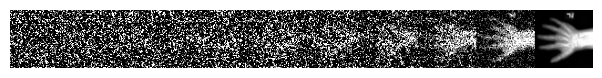

In [12]:
model.eval()
noise = torch.randn((1, 1, 64, 64))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
image, intermediates = inferer.sample(
    input_noise=noise, diffusion_model=model, scheduler=scheduler, save_intermediates=True, intermediate_steps=100
)

chain = torch.cat(intermediates, dim=-1)

plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

### Cleanup data directory

Remove directory if a temporary was used.

In [13]:
if directory is None:
    shutil.rmtree(root_dir)